In [19]:
!pip install tensorflow
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install pydot

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


In [20]:
# Checking the Dataset
from pathlib import Path
import imghdr
import os

data_dir = "hair_types"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions
num_skipped = 0

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            num_skipped += 1
            os.remove(filepath)

print(f"Deleted {num_skipped} images.")

Deleted 0 images.


In [21]:
# Using a DataLoader for Data Loading
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

image_size = (180, 180) # to increase resolution; original: (64, 64)
batch_size = 16 # to have less images per iteration of each epoch; original: 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types/",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types/",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical'
)

Found 981 files belonging to 3 classes.
Using 785 files for training.
Found 981 files belonging to 3 classes.
Using 196 files for validation.


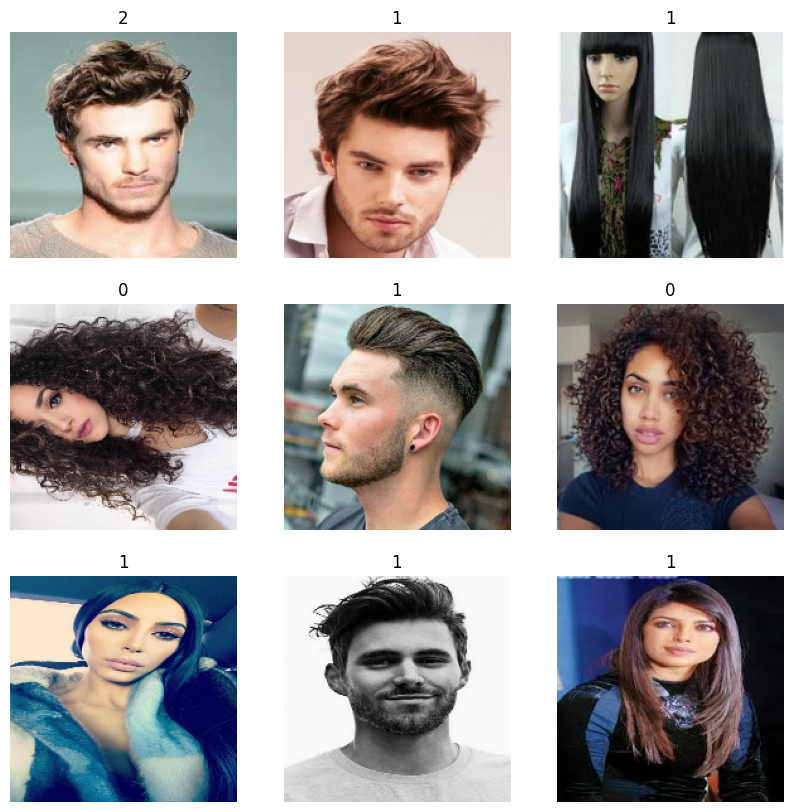

In [22]:
# Data Visualization
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(np.argmax(labels[i])))
        plt.axis("off")
plt.show()

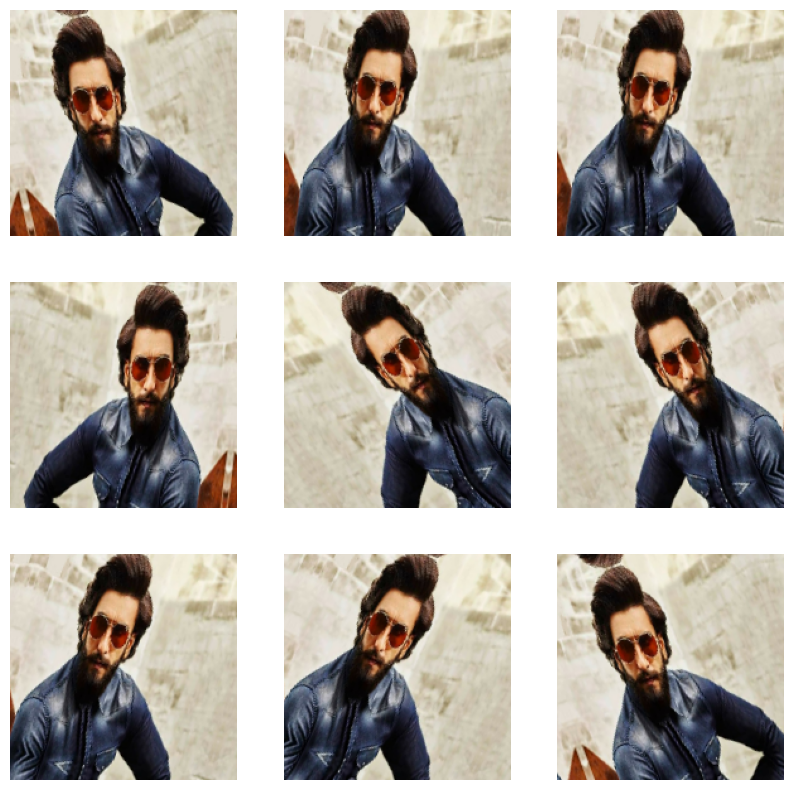

In [23]:
# Using Image Data Augmentation (slows down overfitting)
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def data_augmentation(images):
  for layer in data_augmentation_layers:
    images = layer(images)
  return images

plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(np.array(augmented_images[0]).astype("uint8"))
    plt.axis("off")

In [24]:
# Applying Data Augmentaion to the training images
train_ds = train_ds.map(
    lambda image, label: (data_augmentation(image), label),
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
)

# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.experimental.AUTOTUNE)

In [25]:
# Building a model
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense

def make_model(input_shape, num_classes):
  inputs = keras.Input(shape=input_shape)

  # Entry block
  x = layers.Rescaling(1.0 / 255)(inputs)
  x = layers.Conv2D(64, 3, strides=2, padding="same")(x) # increased the number of strides; original: 1
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  previous_block_activation = x # setting aside residual

  for size in [256, 512, 728]:
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x) # added Max Pooling; increased the number of strides

    # Project residual
    residual = layers.Conv2D(size, 1, strides=2, padding="same")(
        previous_block_activation
    )
    x = layers.add([x, residual]) # added back residual
    previous_block_activation = x # setting aside next residual

  x = layers.SeparableConv2D(1024, 3, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.GlobalAveragePooling2D()(x)
  if num_classes == 3:
    units = 3
  else:
    units = num_classes

  x = layers.Dropout(0.25)(x)
  outputs = layers.Dense(units, activation="softmax")(x)
  return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=3)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [26]:
# Training the model
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]

model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=[keras.metrics.CategoricalAccuracy(name="acc")],
)

model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 275s 5s/step - acc: 0.4689 - loss: 1.0959 - val_acc: 0.2857 - val_loss: 1.1009
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 270s 5s/step - acc: 0.6066 - loss: 0.8845 - val_acc: 0.2857 - val_loss: 1.1059
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 271s 5s/step - acc: 0.6056 - loss: 0.8435 - val_acc: 0.2857 - val_loss: 1.1096
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 271s 5s/step - acc: 0.6529 - loss: 0.7773 - val_acc: 0.2857 - val_loss: 1.1188
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 270s 5s/step - acc: 0.6742 - loss: 0.7029 - val_acc: 0.2857 - val_loss: 1.1328
Epoch 6/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 272s 5s/step - acc: 0.6733 - loss: 0.7107 - val_acc: 0.2857 - val_loss: 1.1535
Epoch 7/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 271s 5s/step - acc: 0.7144 - loss: 0.6621 - val_acc: 0.2857 - val_loss: 1.1754
Epoch 8/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 271s 5s/step - acc: 0.7146 - loss: 0.6699 - val_acc: 0.2857 - val_loss: 1.1754
Epoch 9/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 270s 5s/step - acc: 0.7656

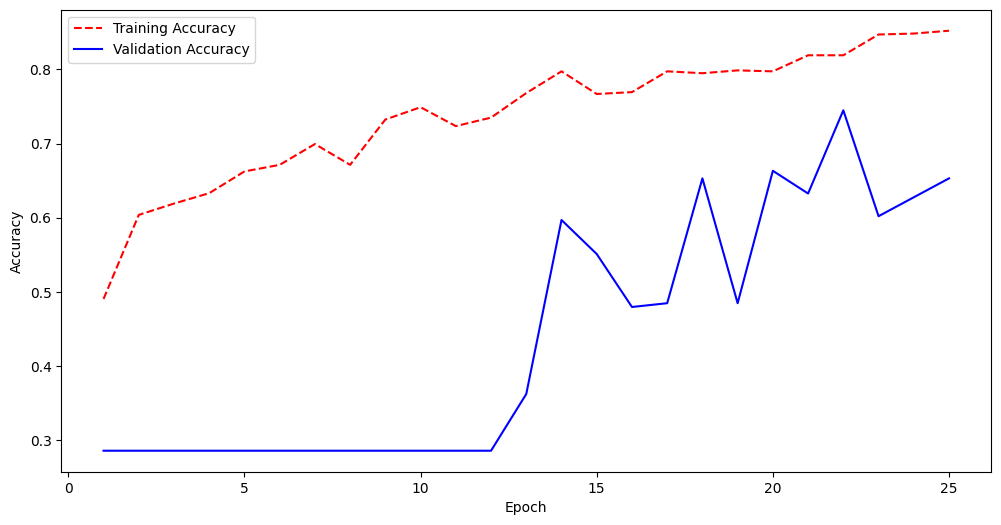

In [27]:
# Get training and test loss histories
training_accuracy = model.history.history['acc']
validation_accuracy = model.history.history['val_acc']

# Create count of the number of epochs
epoch_count = range(1, len(training_accuracy) + 1)

# Visualize loss history
plt.figure(figsize=(12,6))
plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, validation_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step
This image is 57.61% curly hair, 21.19% straight hair, and 21.20% wavy hair.


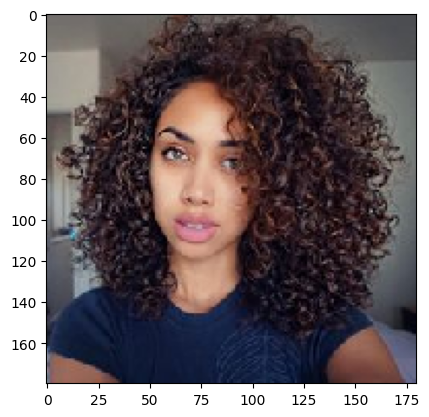

In [28]:
# Test with a sample image
# Load and preprocess the image
img = keras.preprocessing.image.load_img(
    "hair_types/Curly_Hair/02dac897d1dec9ba8c057a11d041ada8--layered-natural-hair-natural-black-hairstyles.jpg",
    target_size=image_size
)
plt.imshow(img)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

# Predict
predictions = model.predict(img_array)
softmax_probabilities = tf.nn.softmax(predictions[0]).numpy()

print(
    "This image is %.2f%% curly hair, %.2f%% straight hair, and %.2f%% wavy hair."
    % tuple(softmax_probabilities * 100)
)

In [29]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 180, 180,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 90, 90,    │      1,792 │ rescaling_2[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 90,    │        256 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 90, 90,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 90, 90,    │          0 │ activation_16[0]… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_14 │ (None, 90, 90,    │     17,216 │ activation_17[0]… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 90,    │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 90, 90,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_15 │ (None, 90, 90,    │     68,096 │ activation_18[0]… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 90,    │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 45, 45,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 45, 45,    │     16,640 │ activation_16[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 45, 45,    │          0 │ max_pooling2d_6[… │
│                     │ 256)              │            │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 45, 45,    │          0 │ add_6[0][0]       │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_16 │ (None, 45, 45,    │    133,888 │ activation_19[0]… │
│ (SeparableConv2D)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 45,    │      2,048 │ separable_conv2d

 Total params: 8,076,851 (30.81 MB)

 Trainable params: 2,689,563 (10.26 MB)

 Non-trainable params: 8,160 (31.88 KB)

 Optimizer params: 5,379,128 (20.52 MB)